In [1]:
import sys
sys.path.append('..')

In [2]:
from importlib import reload
from os.path import exists

import networkx as nx
import numpy as np
import pandas as pd
import lib.obo
import lib.classification.elastic
import lib.classification.validation
import lib.utils
import data
import pymonad

reload(lib.classification.validation)
reload(lib.classification.elastic)
reload(lib.obo)
reload(lib.utils)
reload(data)

from lib.classification.elastic import annotate_index, collapse_matches, build_synonyms_graph
from lib.utils import map_series, expand_dataframe, expand, flatten
from lib.classification.validation import correct_ratio, incorrect_ratio, perfect_match
from geo_annotation.import_ontology_es import import_ontology
from elasticsearch import Elasticsearch
from lib.obo import read_ontology, Ontology
pd.set_option('display.width', 512)

In [3]:
import seaborn
%matplotlib inline

In [4]:
es = Elasticsearch()
ontology = read_ontology('../data/geo-annotation/doid-patched.obo',
                         exclude_duplicates=True)

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 6595
Number of edges: 6594
Average in degree:   0.9998
Average out degree:   0.9998


In [5]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [6]:
import_ontology(ontology, 'disease_ontology')
syn_ontology = Ontology(build_synonyms_graph(ontology, es, 'disease_ontology'), list(ontology.items()))

In [7]:
import pymongo
db = pymongo.MongoClient().scraper_meta
series_ids = [int(d['accession'][3:]) for d in db.series.find({'organism': 'Homo sapiens'}, {'_id': 0, 'accession': 1})]

In [8]:
series_ids[:10]

[43950, 7547, 7563, 7606, 43860, 43862, 43876, 43878, 43880, 43881]

In [9]:
annotation_result_file = '../data/geo-annotation/series.disease.res.homo.1.pickle'
if not exists(annotation_result_file):
    res = annotate_index(client=es,
                         ontology=ontology,
                         index='series',
                         ids=series_ids
                        )

    res.to_pickle(annotation_result_file)

else:
    res = pd.read_pickle(annotation_result_file)

In [10]:
len(res), len(series_ids)

(12495, 20177)

In [11]:
def doid_id(item_id):
    return "DOID:{:07}".format(item_id)


def ontology_name(item_id):
    if item_id not in ontology.meta:
        return item_id
    return ontology.meta[item_id].name


def to_name(series_id):
    return "GSE{}".format(series_id)

def name(item_id):
    return '{} ({})'.format(ontology_name(item_id), item_id)

def names(df):
    return df.applymap(lambda xs: [name(x) for x in xs])

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'DOID:4', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)

def matches_graph(matches, vd_classes=None, figsize=None, prog='neato'):
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(matches + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

    
names_dict = dict((record.id, record.name) for record in ontology.meta.values())

In [12]:
cell_type_cancer = 'DOID:0050687'
organ_system_cancer = 'DOID:0050686'
cell_type_benign_neoplasm = 'DOID:0060084'
organ_system_benign_neoplasm = 'DOID:0060085'

@pymonad.curry
def exclude_similar_branches(ontology, classes):
    has_osc = any(ontology.has_path(organ_system_cancer, c) for c in classes)
    if has_osc:
        return [c for c in classes if not ontology.has_path(cell_type_cancer, c) 
#                                       and not ontology.has_path(cell_type_benign_neoplasm, c)
#                                       and not ontology.has_path(organ_system_benign_neoplasm, c) 
               ]
    else:
        return classes

In [13]:
root_disease = 'DOID:4'

@pymonad.curry
def exclude_wide_terms(ontology, classes):
    threshold = 4
    
    return [c for c in classes 
            if len(nx.shortest_path(ontology.graph, root_disease, c)) > threshold]

In [14]:
results = pd.DataFrame(dict(
        odinary=res.classes,
        collapsed=res.classes.map(exclude_wide_terms(ontology) *
                                  collapse_matches(ontology.graph)),
        collapsed_ex=res.classes.map(exclude_wide_terms(ontology) * 
                                     exclude_similar_branches(ontology) *
                                     collapse_matches(ontology.graph)),
#         collapsed_syn=res.classes.map(collapse_matches(syn_ontology.graph) *
#                                      exclude_wide_terms(ontology) * 
#                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
#         larisa=larisa_vd.classes,
    )
).applymap(lambda x: [] if isinstance(x, float) else x)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108c1ceb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1081a4f60>]], dtype=object)

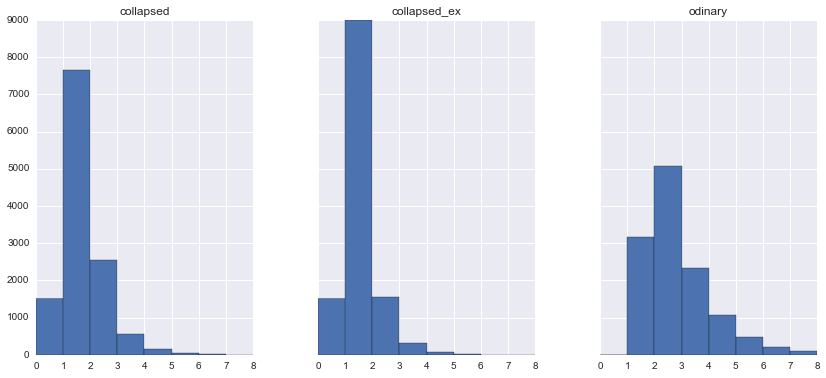

In [15]:
(
    results
    .applymap(len).hist(bins=range(0, 9), 
                        sharey=True, 
                        layout=(1, 3),
                        figsize=(14, 6))
 )

In [15]:
root_node = 'DOID:4'
root_node = 'DOID:162'
def descendants_level(graph, node, level):
    if level == 0:
        return [node]
    else:
        successors = graph.successors(node)
        res = []
        for succ in successors:
            res += descendants_level(graph, succ, level - 1)
        return res    
higer_nodes = [n for n in descendants_level(ontology.graph, root_node, 2)]
len(higer_nodes)

24

In [16]:
def cell():
    from collections import defaultdict
    aggreg = defaultdict(int)
    classes = results.collapsed_ex
    classes = (
        classes[classes.map(lambda x: len(x) == 1)].map(lambda x: x[0]).tolist()
    )
    
    for c in classes:
        for n in higer_nodes:
            if n == c or ontology.has_path(n, c):
                aggreg[n] += 1
                
    return pd.DataFrame.from_records(list(aggreg.items()), columns=['doid', 'count'])
stats = cell().sort(columns=['count'], ascending=False).assign(name=lambda x: x['doid'].map(name))
stats
    

,doid,count,name
1,DOID:5093,1432,thoracic cancer (DOID:5093)
9,DOID:0060083,1245,immune system cancer (DOID:0060083)
15,DOID:3119,1093,gastrointestinal system cancer (DOID:3119)
18,DOID:193,942,reproductive organ cancer (DOID:193)
11,DOID:0050615,456,respiratory system cancer (DOID:0050615)
0,DOID:3093,281,nervous system cancer (DOID:3093)
19,DOID:0060100,270,musculoskeletal system cancer (DOID:0060100)
7,DOID:1909,257,melanoma (DOID:1909)
6,DOID:3070,235,malignant glioma (DOID:3070)
16,DOID:305,234,carcinoma (DOID:305)


In [17]:
stats['count'].sum()

7027

## Список проаннотированных серий

In [16]:
results[results.collapsed_ex.map(lambda c: len(c) == 1)]

,collapsed,collapsed_ex,odinary
item,,,
3,"[DOID:305, DOID:4467]",[DOID:4467],"[DOID:4467, DOID:4450, DOID:305, DOID:162, DOI..."
65540,[DOID:9970],[DOID:9970],[DOID:9970]
16,[DOID:1612],[DOID:1612],"[DOID:1612, DOID:162]"
17,[DOID:440],[DOID:440],"[DOID:4, DOID:440]"
21849,[DOID:0050745],[DOID:0050745],"[DOID:0060058, DOID:707, DOID:0050745]"
31,[DOID:161],[DOID:161],"[DOID:161, DOID:8866]"
65568,[DOID:1909],[DOID:1909],"[DOID:4, DOID:1909]"
65569,[DOID:1909],[DOID:1909],"[DOID:4, DOID:1909]"
20295,[DOID:14330],[DOID:14330],"[DOID:4, DOID:14330]"


In [16]:
series_ids = ['GSE{}'.format(s) for s in results[results.collapsed_ex.map(lambda c: len(c) == 1)].index.tolist()]

r = list(db.series.find({'accession': {'$in': series_ids}}, 
              {
        '_id': 0,
        'accession': 1,
        'samples': 1,
        'platforms': 1    
    }))

In [17]:
series_samples = dict((s['accession'], s['samples']) for s in r)
series_platforms = dict((s['accession'], s['platforms']) for s in r)


In [21]:
# series_samples

In [18]:
series_disease = (
    results[results.collapsed_ex.map(lambda c: len(c) == 1)]['collapsed_ex']
    .reset_index()
    .rename(columns={
            'item': 'series',
            'collapsed_ex': 'doid'
        })
    .assign(doid=lambda d: d['doid'].map(lambda doid: doid[0]))
    .assign(disease=lambda d: d['doid'].map(lambda doid: ontology.meta[doid].name))
    .sort('series')
    .assign(series=lambda d: d['series'].map('GSE{}'.format))
    .assign(samples_count=lambda d: d['series'].map(lambda s: len(series_samples[s])))
    .assign(platforms=lambda d: d['series'].map(lambda s: series_platforms[s]))
)
series_disease

,series,doid,disease,samples_count,platforms
0,GSE3,DOID:4467,renal clear cell carcinoma,342,"[GPL9, GPL10]"
2,GSE16,DOID:1612,breast cancer,25,[GPL28]
3,GSE17,DOID:440,neuromuscular disease,2,[GPL4]
5,GSE31,DOID:161,keratosis,5,[GPL4]
9,GSE49,DOID:1612,breast cancer,10,[GPL179]
10,GSE53,DOID:1612,breast cancer,26,[GPL170]
11,GSE59,DOID:1612,breast cancer,68,"[GPL167, GPL169]"
12,GSE62,DOID:2237,hepatitis,6,"[GPL167, GPL168, GPL169]"
13,GSE88,DOID:11054,urinary bladder cancer,31,[GPL80]
14,GSE89,DOID:11054,urinary bladder cancer,40,[GPL80]


In [20]:
series_disease.to_pickle('../data/geo-annotation/series_disease.pickle')

In [19]:
series_disease.shape

(8992, 5)

In [23]:
series_disease.samples_count.sum()

398410

In [20]:
(
    series_disease
    [series_disease.platforms.map(lambda p: p is not None)]
#     .platforms.map(type).value_counts()
    .assign(platforms=lambda d: d.platforms.map(','.join))
#     .to_csv('../data/geo-annotation/res.series-disease-all-platforms.2.csv')
)

,series,doid,disease,samples_count,platforms
0,GSE3,DOID:4467,renal clear cell carcinoma,342,"GPL9,GPL10"
2,GSE16,DOID:1612,breast cancer,25,GPL28
3,GSE17,DOID:440,neuromuscular disease,2,GPL4
5,GSE31,DOID:161,keratosis,5,GPL4
9,GSE49,DOID:1612,breast cancer,10,GPL179
10,GSE53,DOID:1612,breast cancer,26,GPL170
11,GSE59,DOID:1612,breast cancer,68,"GPL167,GPL169"
12,GSE62,DOID:2237,hepatitis,6,"GPL167,GPL168,GPL169"
13,GSE88,DOID:11054,urinary bladder cancer,31,GPL80
14,GSE89,DOID:11054,urinary bladder cancer,40,GPL80


In [29]:
(
    series_disease
    [series_disease.platforms.map(lambda p: p is not None)]
#     .platforms.map(type).value_counts()
    .assign(platforms=lambda d: d.platforms.map(','.join))
    .groupby('platforms')
    .samples_count
    .sum()
    .to_frame()
    .sort('samples_count', ascending=False)
    [:20]
#     .samples_count.sum()
#     .to_csv('../data/geo-annotation/res.series-disease-all-platforms.2.csv')
)

,samples_count
platforms,
GPL570,58312
GPL96,18778
GPL10558,12854
GPL6244,11356
GPL8490,9291
GPL6801,8658
GPL13534,8314
GPL6947,7527
GPL571,6148


In [76]:
series_disease[series_disease.platforms.map(lambda p: listinlist(['GPL570', 'GPL571', 'GPL96'], p) if p else False)][['series', 'doid', 'disease', 'samples_count']]\
.to_csv('../data/preproc/res.series-disease.preprocessed.2.csv', index=False)

In [2]:
import pandas  as pd
pd.read_csv('../data/preproc/res.series-disease.preprocessed.2.csv')

,series,doid,disease,samples_count
0,GSE430,DOID:6000,congestive heart failure,14
1,GSE473,DOID:2841,asthma,175
2,GSE474,DOID:9970,obesity,24
3,GSE475,DOID:3083,chronic obstructive pulmonary disease,7
4,GSE567,DOID:2228,thrombocytosis,2
5,GSE620,DOID:1485,cystic fibrosis,22
6,GSE635,DOID:9952,acute lymphocytic leukemia,173
7,GSE781,DOID:4467,renal clear cell carcinoma,34
8,GSE873,DOID:437,myasthenia gravis,5
9,GSE923,DOID:1485,cystic fibrosis,19


In [55]:
def listinlist(list1, list2):
    return any(x1 in list2 for x1 in list1)

In [60]:
samples_count = (
 series_disease[series_disease.platforms.map(lambda p: listinlist(['GPL570', 'GPL571', 'GPL96'], p) if p else False)][['doid', 'disease', 'samples_count']]
 .groupby(['doid', 'disease'], as_index=False)
 .samples_count.sum()
 .sort('samples_count', ascending=False)
)
samples_count

,doid,disease,samples_count
131,DOID:1612,breast cancer,17096
347,DOID:9538,multiple myeloma,5431
353,DOID:9952,acute lymphocytic leukemia,4826
338,DOID:9119,acute myeloid leukemia,4736
107,DOID:1324,lung cancer,4446
158,DOID:2394,ovarian cancer,2953
14,DOID:0050745,diffuse large b-cell lymphoma,2926
95,DOID:1240,leukemia,2923
343,DOID:9256,colorectal cancer,2760
150,DOID:219,colon cancer,2621


In [62]:
samples_count.to_csv('../data/preproc/res.samples-by-disease.2.csv', index=False)

In [40]:
root_node = 'DOID:4'
root_node = 'DOID:162'

def level_counts(root_node, level):
    def descendants_level(graph, node, level):
        if level == 0:
            return [node]
        else:
            successors = graph.successors(node)
            res = []
            for succ in successors:
                res += descendants_level(graph, succ, level - 1)
            return res    
    higer_nodes = [n for n in descendants_level(ontology.graph, root_node, level)] + [root_node]
    len(higer_nodes)
    
    @pymonad.curry
    def get_top_disease(higher_nodes, doid):
        res =[node for node in higer_nodes if ontology.has_path(node, doid)]
        if res:
            return res[0]
        else:
            return np.nan
    
    return (
        series_disease
        .assign(top_doid=series_disease.doid.map(get_top_disease(higer_nodes)))
        .groupby('top_doid')
        .samples_count
        .sum()
        .to_frame()
        .sort('samples_count', ascending=False)
        .assign(name=lambda d: d.index.map(name))
    )

In [45]:
level_counts('DOID:7', 1)

,samples_count,name
top_doid,,
DOID:1287,11791,cardiovascular system disease (DOID:1287)
DOID:1579,9854,respiratory system disease (DOID:1579)
DOID:77,8195,gastrointestinal system disease (DOID:77)
DOID:863,7996,nervous system disease (DOID:863)
DOID:2914,7689,immune system disease (DOID:2914)
DOID:17,7110,musculoskeletal system disease (DOID:17)
DOID:16,3618,integumentary system disease (DOID:16)
DOID:15,1543,reproductive system disease (DOID:15)
DOID:18,542,urinary system disease (DOID:18)


In [39]:
name('DOID:4')

'disease (DOID:4)'